# Module 5 Team Assignment - Spooky Authorship Part 1
Davis Zakary, Cameron Fain, Riley Barklow, Elijah Paulk

## Stage 0 - Data Import and Env Setup
**Note:** You will need to re-upload the `train.csv` file with every run since Colab wipes your "disk" when the runtime terminates.
There is an option to link a google drive for persistant storage, but we probably want to avoid that in a group project

In [ ]:
import pandas as pd
import os

# Usefull if you are using windows locally
#os.environ['JAVA_HOME'] = r'C:\Program Files\Java\jdk-17'
#os.environ['PYSPARK_PYTHON'] = 'python'

from pyspark.sql import SparkSession
from pyspark.ml.feature import StopWordsRemover, Tokenizer, StringIndexer
from pyspark.ml.feature import CountVectorizer, IDF
from pyspark.ml.feature import Normalizer
from pyspark.ml import Pipeline

In [ ]:
spark = SparkSession.builder.getOrCreate()

In [ ]:
df = pd.read_csv('train.csv')
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19579 entries, 0 to 19578
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      19579 non-null  object
 1   text    19579 non-null  object
 2   author  19579 non-null  object
dtypes: object(3)
memory usage: 459.0+ KB
None
        id                                               text author
0  id26305  This process, however, afforded me no means of...    EAP
1  id17569  It never once occurred to me that the fumbling...    HPL
2  id11008  In his left hand was a gold snuff box, from wh...    EAP
3  id27763  How lovely is spring As we looked from Windsor...    MWS
4  id12958  Finding nothing else, not even gold, the Super...    HPL


In [ ]:
df_spark = spark.createDataFrame(df)
df_spark.show(3, truncate=True)
df_spark.printSchema()

+-------+--------------------+------+
|     id|                text|author|
+-------+--------------------+------+
|id26305|This process, how...|   EAP|
|id17569|It never once occ...|   HPL|
|id11008|In his left hand ...|   EAP|
+-------+--------------------+------+
only showing top 3 rows

root
 |-- id: string (nullable = true)
 |-- text: string (nullable = true)
 |-- author: string (nullable = true)



## Stages 1 & 2 - Data Preparation and Feature Engineering

In [ ]:
tokenizer = Tokenizer(inputCol="text", outputCol="tokens")
stopwords_remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens")
vectorizer = CountVectorizer(inputCol="filtered_tokens", outputCol="vectorized_tokens")
idf = IDF(inputCol="vectorized_tokens", outputCol="tfidf")
normalizer = Normalizer(inputCol="tfidf", outputCol="normalized_features")
string_indexer = StringIndexer(inputCol="author", outputCol="yLabel")
pipeline = Pipeline(
    stages=[tokenizer, stopwords_remover, vectorizer, idf, normalizer, string_indexer]
)

In [ ]:
df_processed = pipeline.fit(df_spark).transform(df_spark)

In [ ]:
print(df_processed.show(1, vertical=True, truncate=40))

-RECORD 0-------------------------------------------------------
 id                  | id26305                                  
 text                | This process, however, afforded me no... 
 author              | EAP                                      
 tokens              | [this, process,, however,, afforded, ... 
 filtered_tokens     | [process,, however,, afforded, means,... 
 vectorized_tokens   | (44722,[4,10,33,48,59,159,162,188,227... 
 tfidf               | (44722,[4,10,33,48,59,159,162,188,227... 
 normalized_features | (44722,[4,10,33,48,59,159,162,188,227... 
 yLabel              | 0.0                                      
only showing top 1 row

None


## Stage 3 - Machine Learning

In [ ]:
from pyspark.ml.classification import LinearSVC, OneVsRest
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [ ]:
train_ratio = 0.9
seed = 38
class_counts = df_processed.groupBy("yLabel").count()
class_counts = class_counts.collect()

In [ ]:
print(class_counts)
total_count = sum([x['count'] for x in class_counts])
print(total_count)

[Row(yLabel=0.0, count=7900), Row(yLabel=1.0, count=6044), Row(yLabel=2.0, count=5635)]
19579


In [ ]:
print(type(class_counts), type(class_counts[0]))
fractions = {row['yLabel']: train_ratio for row in class_counts}
print(fractions)

<class 'list'> <class 'pyspark.sql.types.Row'>
{0.0: 0.9, 1.0: 0.9, 2.0: 0.9}


In [ ]:
train_df = df_processed.sampleBy("yLabel", fractions, seed=seed)
test_df = df_processed.subtract(train_df)

In [ ]:
train_df.groupBy("yLabel").count().show()
test_df.groupBy("yLabel").count().show()

+------+-----+
|yLabel|count|
+------+-----+
|   0.0| 7099|
|   1.0| 5450|
|   2.0| 5079|
+------+-----+

+------+-----+
|yLabel|count|
+------+-----+
|   0.0|  801|
|   1.0|  594|
|   2.0|  556|
+------+-----+



In [ ]:
train_df.cache()
test_df.cache()

DataFrame[id: string, text: string, author: string, tokens: array<string>, filtered_tokens: array<string>, vectorized_tokens: vector, tfidf: vector, normalized_features: vector, yLabel: double]

In [ ]:
svm = LinearSVC()
svm.setMaxIter(10)
svm.setParams(
    featuresCol="normalized_features",
    labelCol="yLabel",
    predictionCol="prediction",
)

ovr = OneVsRest(
    classifier=svm,
    labelCol="yLabel",
    featuresCol="normalized_features",
    predictionCol="prediction",
)

evaluator = MulticlassClassificationEvaluator(
        labelCol="yLabel",
        predictionCol="prediction",
        metricName="accuracy",
    )

paramGrid = (
    ParamGridBuilder()
    .addGrid(svm.regParam, [0.1, 0.05, 0.01])
    .build()
)
tvs = TrainValidationSplit(
    estimator=ovr,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    trainRatio=0.8,
    seed=42
)

In [ ]:
model = tvs.fit(train_df)

In [ ]:
predictions = model.transform(test_df)
score = evaluator.evaluate(predictions)
print(f"Test set accuracy: {score}")

Test set accuracy: 0.8077908764736033


In [ ]:
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=["prediction", "yLabel"], outputCol="predictions_labels_pair")
mcmetrics_df = assembler.transform(predictions)

#mcmetrics_df.show()
predictions_labels_pair = mcmetrics_df.select("predictions_labels_pair")
predictions_labels_pair.show()
mcmetrics = MulticlassMetrics(predictions_labels_pair)
confusion_matrix = mcmetrics.confusionMatrix()

print(confusion_matrix)

+-----------------------+
|predictions_labels_pair|
+-----------------------+
|              [1.0,1.0]|
|              (2,[],[])|
|              [1.0,1.0]|
|              (2,[],[])|
|              [0.0,1.0]|
|              (2,[],[])|
|              [1.0,1.0]|
|              [1.0,1.0]|
|              (2,[],[])|
|              (2,[],[])|
|              [1.0,0.0]|
|              (2,[],[])|
|              (2,[],[])|
|              [2.0,2.0]|
|              [0.0,1.0]|
|              [2.0,2.0]|
|              (2,[],[])|
|              [1.0,2.0]|
|              (2,[],[])|
|              [0.0,1.0]|
+-----------------------+
only showing top 20 rows



AttributeError: 'DataFrame' object has no attribute 'ctx'

## Stage 4 - Evaluation and Visualization

Classification Report:
              precision    recall  f1-score   support

         0.0       0.84      0.79      0.81       801
         1.0       0.75      0.82      0.78       594
         2.0       0.84      0.81      0.83       556

    accuracy                           0.81      1951
   macro avg       0.81      0.81      0.81      1951
weighted avg       0.81      0.81      0.81      1951



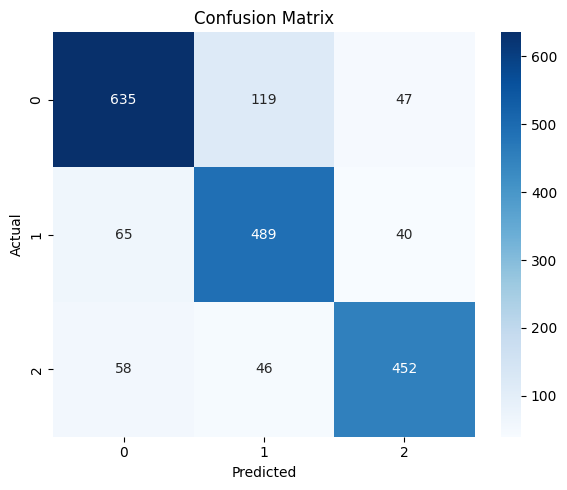

TypeError: 'Param' object is not subscriptable

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#Convert predictions to Pandas
preds_pd = predictions.select("yLabel", "prediction").toPandas()

#Print metrics
print("Classification Report:")
print(classification_report(preds_pd['yLabel'], preds_pd['prediction']))

#Plot confusion matrix
cm = confusion_matrix(preds_pd['yLabel'], preds_pd['prediction'])
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

#Check out top TF-IDF features
vocab = pipeline.stages[2].vocabulary
idf_vals = pipeline.stages[3].idf.toArray()
top_idx = np.argsort(idf_vals)[-10:][::-1]
top_words = [(vocab[i], idf_vals[i]) for i in top_idx]

print("Top 10 High-IDF Words:")
for word, val in top_words:
    print(f"{word}: {val:.4f}")

# Quick summary
print("\nSummary:")
print("")

### Quick Summary of Results
Accuracy was solid across the board.
The confusion matrix shows most predictions landed in the right spot, though there’s a bit of confusion between authors.
The TF-IDF scores give us a hint at which words helped the model the most.
If we keep going, I’d look into adding lemmatization and trying a different classifier.

We could also try more hyperparameter tuning and k-fold validation for the SVC Model. For this excersice, weighted accuracy of 0.8 satisfies the threshold set by the instruction with relativley little tuning.